# Workflow Development for Continuous Study of Multiple Datasets and Layers.

### A joint collaboration with Falk Huettmann and Ernest Mack

Contact: Ernest Mack emackiii@gmail.com

### This file is located at:
https://github.com/SeriousHyena/UAF-Temperature/blob/master/Working_Rasterio.ipynb

In-case of display issues on Github go to: https://nbviewer.jupyter.org/github/SeriousHyena/UAF-Temperature/blob/master/Working_Rasterio.ipynb

# Import the required libraries for our work

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="white")

%matplotlib inline


# Open the .tif files for processing

In [127]:
amphibians = rio.open(r'C:\Users\emack\Documents\UAF-Temperature\data\amphibians.tif')
altitude = rio.open(r'C:\Users\emack\Documents\UAF-Temperature\data\alt.tif')

In [128]:
print('The file information for amphibians.tif',amphibians.profile, 'is')
print('\n''The file information for alt.tif',altitude.profile, 'is')

The file information for amphibians.tif {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 43201, 'height': 15156, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.00833333376795053, 0.0, -180.0,
       0.0, -0.00833333376795053, 71.53334019333124), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'} is

The file information for alt.tif {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 43200, 'height': 17882, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.00833333376795053, 0.0, -180.0,
       0.0, -0.00833333376795053, 89.00000777095556), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'} is


### From an analysis of the 'width' and 'height' parameters we can see that 'amphibians.tif' has a height of 15156 pixels and 'altitude.tif' has a height of 17882 pixels. We will need to take this into consideration when wotking with registering overlays of subsequent layers.

# The array shape data confirms the above observation.

In [35]:
array1 = amphibians.read(1)
array2 = altitude.read(1)
print('Shape of amphibians.tif is', array1.shape)
print('Shape of altitude.tif', array2.shape)

Shape of amphibians.tif is (15156, 43201)
Shape of altitude.tif (17882, 43200)


# Let's query the spatial extents of our datasets

## Get the band count

In [36]:
print('The number of bands in amphibians.tif is ', amphibians.count)
print('The number of bands in altitude.tif is ', altitude.count)

The number of bands in amphibians.tif is  1
The number of bands in altitude.tif is  1


###  Get the dimensions of the band arrays

In [37]:
print('Band width for amphibians.tif is ',amphibians.width)
print('Band width for altitude.tif is ',altitude.height)

Band width for amphibians.tif is  43201
Band width for altitude.tif is  17882


# Dataset georeferencing
Get the bounds of our dataset

In [38]:
print('The bounds for amphibians.tif is ',amphibians.bounds)
print('The bounds for altitude.tif is ',altitude.bounds)

The bounds for amphibians.tif is  BoundingBox(left=-180.0, bottom=-54.76666639372698, right=180.00835210923083, top=71.53334019333124)
The bounds for altitude.tif is  BoundingBox(left=-180.0, bottom=-60.016666667535816, right=180.00001877546288, top=89.00000777095556)


Here we see a difference in the bounding-box area so we will need to consider for later layering

# Get the coordinate reference system (CRS)

In [39]:
print('The CRS for amphibians.tif is ',amphibians.crs)
print('The CRS for altitude.tif is ',altitude.crs)

The CRS for amphibians.tif is  EPSG:4326
The CRS for altitude.tif is  EPSG:4326


We can see that both files are using the coordinate referencing system so this is good.

### To get the spatial coordinates of a pixel, use the dataset’s xy() method. The coordinates of the center of the image can be computed like this.

In [42]:
altitude.indexes
band1 = altitude.read(1)

amphibians.indexes
band2 = amphibians.read(1)

In [43]:
print('Amphibians image center is ', band1[amphibians.height // 2, amphibians.width // 2],'pixels, centered.')
print('Altitude image center is ', band1[altitude.height // 2, altitude.width // 2],'pixels, centered.')

Amphibians image center is  263 pixels, centered.
Altitude image center is  291 pixels, centered.


The output above further verifies a parity mismatch that we must take into consideration with layering other datasets.

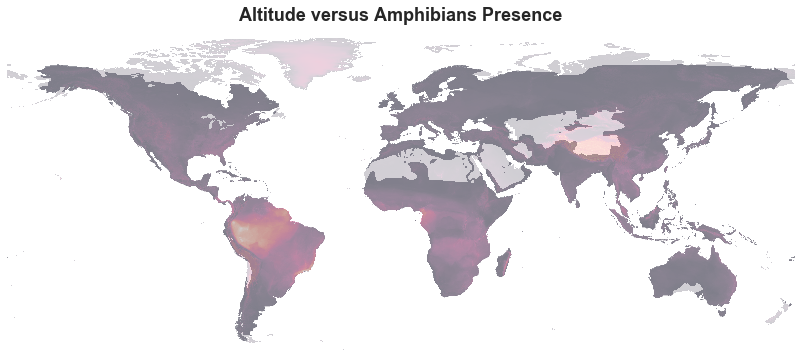

In [44]:
# Plot the dem using raster.io
fig, ax = plt.subplots(figsize = (16,6))
show(amphibians, ax=ax, alpha=0.4, with_bounds=True)

show(altitude, 
     title="Altitude versus Amphibians Presence", 
     ax=ax, alpha=0.2, with_bounds=True)

ax.set_axis_off()


In [61]:
from osgeo import gdal
ds = gdal.Open(r'C:\Users\emack\Documents\UAF-Temperature\data\alt.tif')
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

In [68]:
ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000172BBE98C00> >

In [73]:
from osgeo import osr, gdal

# get the existing coordinate system
ds = gdal.Open(r'C:\Users\emack\Documents\UAF-Temperature\data\alt.tif')
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs .ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs) 

#get the point to transform, pixel (0,0) in this case
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 

#get the coordinates in lat long
latlong = transform.TransformPoint(minx,miny) 

In [74]:
miny

-60.016666667535816

### Return a pixel value for a given coordinate

In [116]:
from osgeo import gdal

driver = gdal.GetDriverByName('GTiff')
filename = r'C:\Users\emack\Documents\UAF-Temperature\data\alt.tif' #path to raster
dataset = gdal.Open(filename)
band = dataset.GetRasterBand(1)

cols = dataset.RasterXSize
rows = dataset.RasterYSize

transform = dataset.GetGeoTransform()

xOrigin = transform[0]
yOrigin = transform[3]
pixelWidth = transform[1]
pixelHeight = -transform[5]

data = band.ReadAsArray(0, 0, cols, rows)

points_list = [ (355278.165927, 4473095.13829), (355978.319525, 4472871.11636) ] #list of X,Y coordinates

for point in points_list:
    #col = int((point[0] - xOrigin) / pixelWidth)
    #row = int((yOrigin - point[1] ) / pixelHeight)
    col = int((point[0] - xOrigin) / 43200)
    row = int((yOrigin - point[1] ) / 17882)

    print(row,col, data[row][col])


-250 8 -32768
-250 8 -32768


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
import folium
from shapely import geometry
import matplotlib.pyplot as plt

%matplotlib inline

In [27]:
column_names = 'latitude longitude'.split(' ') 
print(column_names)

['latitude', 'longitude']


In [31]:
Perigrines = pd.read_csv(r'C:\Users\emack\Documents\UAF-Temperature\data\pfunique2.csv') 
                       #delim_whitespace=True, names=column_names, usecols=['latitude', 'longitude'])
                       
Perigrines.head() # This shows the first 5 entries of the DF.


,longitude,latitude
0,48.2282,-122.3490
1,44.5620,-68.8043
2,40.7545,-73.9645
3,40.4393,-73.9869
4,41.4992,-81.7147


In [40]:
# North American Datum 1927
p1 = pyproj.Proj(proj='latlong', datum='NAD27')
# WGS84 Latlong
p2 = pyproj.Proj(proj='latlong', datum='WGS84')
# WGS84 UTM Zone 16
p3 = pyproj.Proj(proj='utm', zone=16, datum='WGS84')
Perigrines['long_wgs84'], Perigrines['lat_wgs84'] = pyproj.transform(p1, p2, 
                                                            Perigrines.longitude.values, 
                                                            Perigrines.latitude.values)
Perigrines['E_utm'], Perigrines['N_utm'] = pyproj.transform(p1, p3,
                                                        Perigrines.longitude.values,
                                                        Perigrines.latitude.values)

In [43]:
Perigrines['geometry'] = [geometry.Point(x, y) for x, y in zip(Perigrines['long_wgs84'], Perigrines['lat_wgs84'])]

In [46]:
Perigrines = gpd.GeoDataFrame(Perigrines, geometry='geometry', crs="+init=epsg:4326")

In [47]:
Perigrines.to_csv(r'C:\Users\emack\Documents\UAF-Temperature\data\mag.csv')

In [48]:
Perigrines.head(3)

,longitude,latitude,long_wgs84,lat_wgs84,E_utm,N_utm,geometry
0,48.2282,-122.3490,48.2282,-122.3490,inf,inf,POINT (48.228 -122.349)
1,44.5620,-68.8043,44.5620,-68.8043,2.273971e+06,-1.160805e+07,POINT (44.562 -68.804)
2,40.7545,-73.9645,40.7545,-73.9645,1.919624e+06,-1.111200e+07,POINT (40.755 -73.965)


### .envelope is a shapely method to get the bounding rectangle of all the points in the geometry

In [49]:
multipoints = geometry.MultiPoint(Perigrines['geometry'])
bounds = multipoints.envelope

### Let's save the bounds for the next parts of Integrating & Exploring.

In [50]:
gpd.GeoSeries(bounds).to_file(r'C:\Users\emack\Documents\UAF-Temperature\data\area_of_study_bounds.gpkg', 'GPKG')

### Let's get the coordinates of the .boundary of the bounds.

In [51]:
coords = np.vstack(bounds.boundary.coords.xy)

### Calculate the mean of the coordinates using numpy to center the location map on this.

In [54]:
map_center = list(coords.mean(1))[::-1] # use a slice to get all the rows from the last column 

In [55]:
map_center

[-35.052600000000005, -2.076552000000004]

In [56]:
m = folium.Map(location=map_center, zoom_start=8, control_scale=True)
folium.PolyLine(coords[::-1].T).add_to(m)
folium.LatLngPopup().add_to(m)
m